# Kaggle's Titanic survival prediction

This notebook creates a competition entry to Kaggle's [Titanic survival competition](https://www.kaggle.com/competitions/titanic/overview). The aim is to predict passenger's survival on Titanic based on the given data. The datasets are freely available on [Kaggle](https://www.kaggle.com/competitions/titanic/data?select=gender_submission.csv). 

In this notebook we use pandas, seaborn and matplotlib for data visualisation and manipulation and skelarn for creating the training pipeline. We are especially interested in trying out sklearn's ColumnTransformer and Pipeline in together with GridSearch. We try to avoid unnecessary feature engineering and create a simple solution for the task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pandas.api.types import is_numeric_dtype
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

%matplotlib inline

## 1. Read data into dataframes

First we create functions for reading the data into dataframes and dropping the columns that are only used for identyfing passengers.

In [2]:
def read_train_data():
    train_org = pd.read_csv("train.csv", sep=",")
    train_org = train_org.drop(["Name", "Ticket"], axis=1)
    return train_org

def read_test_data():
    test_org = pd.read_csv("test.csv", sep=",")
    test_org = test_org.drop(["Name", "Ticket"], axis=1)
    return test_org

## 2. Look at the data

Let's take a look at the available training data.

Column names and datatypes:
 PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Cabin           object
Embarked        object
dtype: object

***PassengerId***
For identifying passengers, needed for final submission.

***Survived***
0    549
1    342
Name: Survived, dtype: int64
Survival rate: 0.38


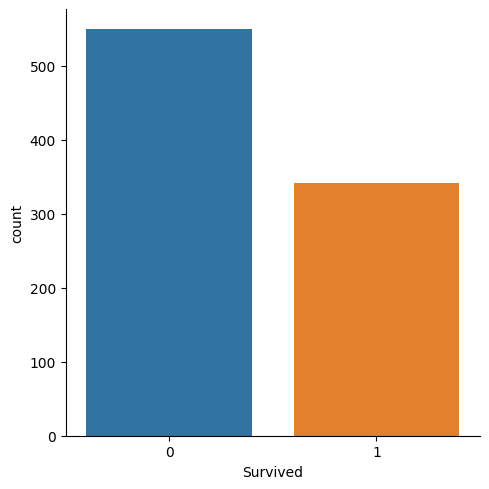


***Pclass***
3    491
1    216
2    184
Name: Pclass, dtype: int64


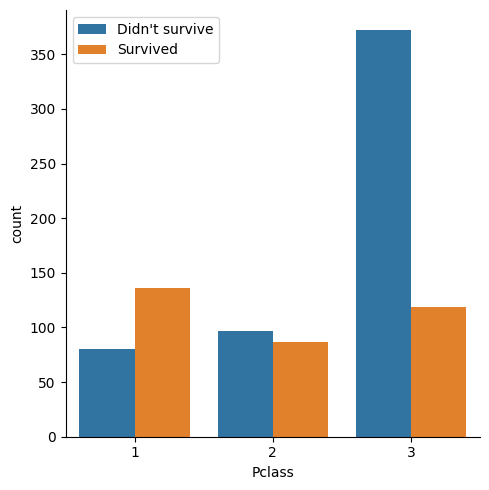


***Sex***
male      577
female    314
Name: Sex, dtype: int64


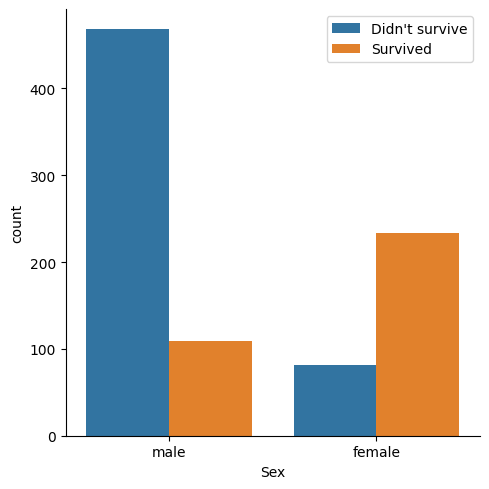


***Age***
!!! 177 / 891 nan values in column 'Age' !!!
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


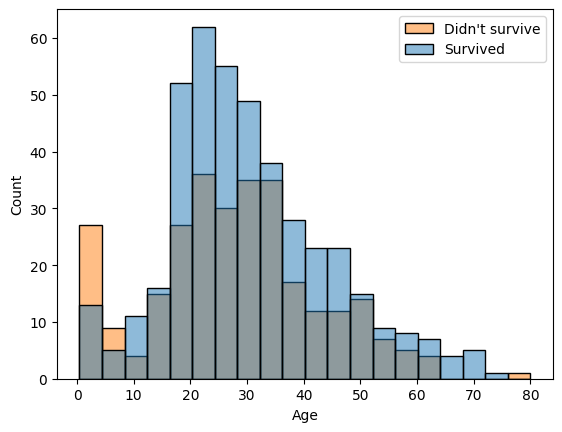


***SibSp***
count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64


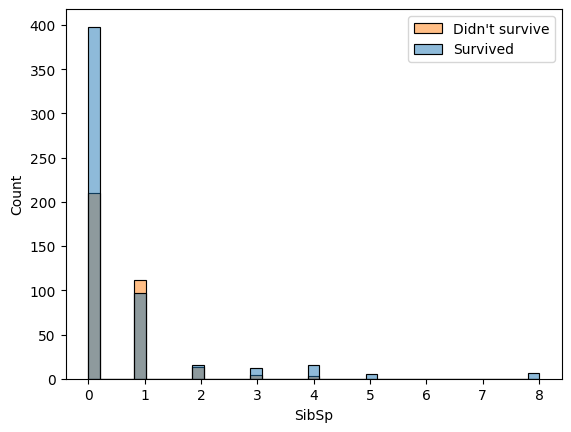


***Parch***
count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64


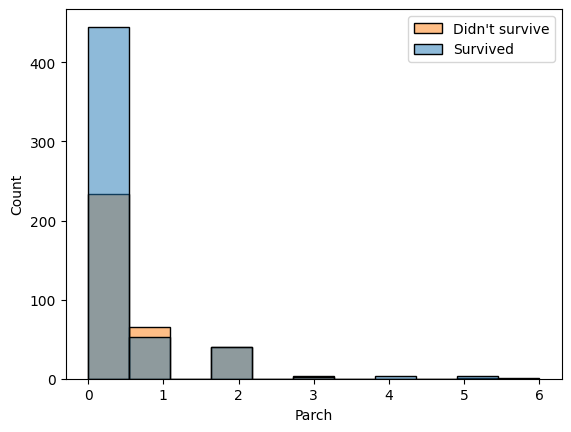


***Fare***
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


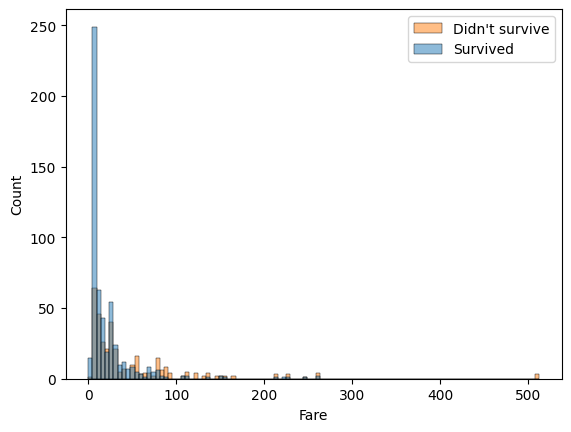


***Cabin***
!!! 687 / 891 nan values in column 'Cabin' !!!
Original `Cabin` info: 
 B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64


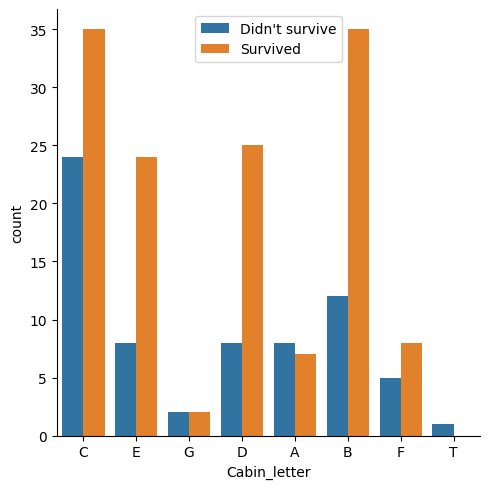


***Embarked***
!!! 2 / 891 nan values in column 'Embarked' !!!
S    644
C    168
Q     77
Name: Embarked, dtype: int64


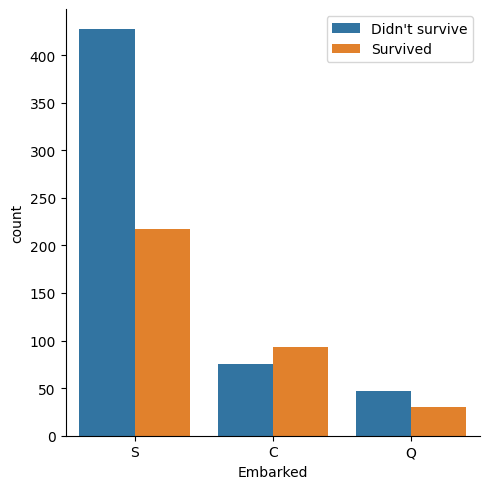

In [3]:
def print_basic_info(df: pd.DataFrame) -> None:
    df_len = len(df)
    print("Column names and datatypes:\n", df.dtypes)
    
    for col in df.columns:
        print(f"\n***{col}***")
        nans = len(df[df[col].isna() == 1])
        if nans > 0:
            print(f"!!! {nans} / {df_len} nan values in column '{col}' !!!")
        if col == "PassengerId":
            print("For identifying passengers, needed for final submission.")
            continue
        if col == "Survived":
            print(df[col].value_counts())
            print("Survival rate: {:.2f}".format(df["Survived"].sum()/df["Survived"].count()))
            sns.catplot(df, x=col, kind="count", hue="Survived", legend=False)
            plt.show()
        elif is_numeric_dtype(df.dtypes[col]) and df[col].nunique() > 3:
            print(df.describe()[col])
            sns.histplot(df, x=col, hue="Survived", legend=False)
            plt.legend(labels=["Didn't survive", "Survived"])
            plt.show()
        elif df[col].nunique() <= 3:
            print(df[col].value_counts())
            sns.catplot(df, x=col, kind="count", hue="Survived", legend=False)
            plt.legend(labels=["Didn't survive", "Survived"])
            plt.show()
        elif col == "Cabin":
            print("Original `Cabin` info: \n", df[col].value_counts())
            df["Cabin_letter"] = df["Cabin"].str[0]
            sns.catplot(df, x="Cabin_letter", hue="Survived", kind="count", legend=False)
            plt.legend(labels=["Didn't survive", "Survived"])
            plt.show()
        else:
            print(df[col].value_counts())
        

train_df = read_train_data()
print_basic_info(train_df)  

The dataset seems quite clean, there are only a few columns with missing datapoints and most of the variables are numeric. Let's go through all of the variables.

### 2.1 Target variable 'Survived'

The aim is to predict the value `Survived`, which is either 1 or 0. This is a binary classification task. 38% of the passengers on the training dataset survived, so the training data is not perfectly balanced. 

### 2.2 Other variables

#### Pclass
Passenger's ticket is either 1st, 2nd or 3rd class. This is a categorical variable although it is represented with integers. We are going to treat this as a categorical variable.

#### Sex
Sex of the passenger represented as `male` or `female`. We are interested in using this variable as a predictive feature and need to relabel it with a numeric value for prediction.

#### Age
Age of the passenger represented in years. The column has 19.9% missing data points. Since we are interested in using `Age` as a predictive variable on our model, and we don't want to discard fifth of the training data, we have to impute these data points.

#### SibSp
Number of siblings / spouses onboard. Most common value is zero, only the upper 25% have a non-zero value. Because this data is uneven, we could try to make this into a category of having or not having siblings/spouses. We could also try to use this as is. 

#### Parch
Number of parents / children onboard. This data is even more uneven than `SibSp`, but we can try to use this as is or as categories, maybe. We could also try to add these two variables into one that describes the overall family size onboard. However, if we do this instead of using the original values, we risk losing some essential information given by the distinction of these two. Using all of the variables, on the other hand, would lead up to collinearity, which is not desirable for logistic regression that we are planning to use.
 
#### Fare
Price of the ticket. There seems to be some outliers in this column, as the maximum value is at least ten times the upper quartile. There are also some free tickets. Fare could be an interesting variable; it could indicate the cabin location onboard or the status of the passenger. However we do allready have the information of the ticket class of each passenger, so it is somewhat questionable wheather fare gives us any extra information.

#### Cabin
The cabin number. This could technically be an interesting variable, if the cabin letter indicates the physical cabin location onboard. Most values are missing, but at least according to the available information there seems to be some clear differences of survival within different "cabin letters". This could be an interesting point to look more closely at, but since we are trying to just make a first attempt at this prediction task, we are going to ignore the `Cabin` info and maybe return to it on later attempts. Missing cabin prediction would likely require a model of it's own.

#### Embarked
Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton. This has to be mapped into numerical data, and we can try to use this as a predictive feature.


### 2.3 Look at correlation

It is possible that some of the variables are correlated with each other. We are interested in using linear model for this prediction, so it is a good idea to check for collinearity. Also `Fare` and `Pclass` might be tightly related... We use Spearman correlation to check for correlation between continuous and ordinal data.

We also need to impute some missing ages, and it would be ideal if we had some better way of doing this than just using mean age. We'll create a feature that describes the size of the family onboard to see if that could be helpful in predicting age of a passenger.

*****Spearman correlation*****
             Survived    Pclass       Sex       Age     SibSp     Parch  \
Survived     1.000000 -0.357628  0.536762 -0.057032  0.075780  0.158864   
Pclass      -0.357628  1.000000 -0.155065 -0.358490 -0.053805 -0.020897   
Sex          0.536762 -0.155065  1.000000 -0.088412  0.168000  0.257697   
Age         -0.057032 -0.358490 -0.088412  1.000000 -0.180426 -0.253183   
SibSp        0.075780 -0.053805  0.168000 -0.180426  1.000000  0.426322   
Parch        0.158864 -0.020897  0.257697 -0.253183  0.426322  1.000000   
Fare         0.335672 -0.728700  0.271077  0.130632  0.427503  0.411009   
Embarked    -0.169571  0.197737 -0.110032 -0.014326 -0.018642 -0.020522   
Family_size  0.164227 -0.079100  0.275003 -0.226405  0.831443  0.810981   

                 Fare  Embarked  Family_size  
Survived     0.335672 -0.169571     0.164227  
Pclass      -0.728700  0.197737    -0.079100  
Sex          0.271077 -0.110032     0.275003  
Age          0.130632 -0.01432

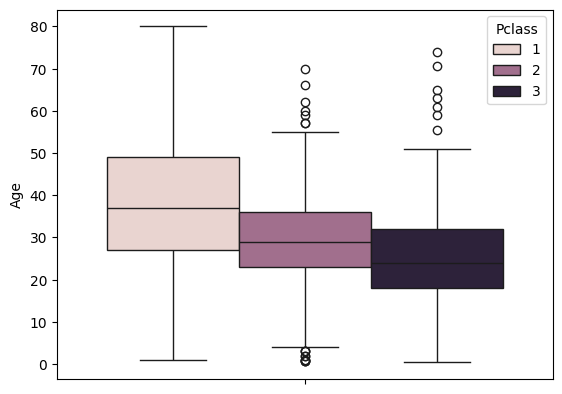

       Survived                                                 Sex            \
          count      mean       std  min  25%  50%  75%  max  count      mean   
Pclass                                                                          
1         184.0  0.652174  0.477580  0.0  0.0  1.0  1.0  1.0  184.0  0.451087   
2         173.0  0.479769  0.501041  0.0  0.0  0.0  1.0  1.0  173.0  0.427746   
3         355.0  0.239437  0.427342  0.0  0.0  0.0  0.0  1.0  355.0  0.287324   

        ... Embarked      Family_size                                          \
        ...      75%  max       count      mean       std  min  25%  50%  75%   
Pclass  ...                                                                     
1       ...      2.0  2.0       184.0  0.869565  1.083582  0.0  0.0  1.0  1.0   
2       ...      2.0  2.0       173.0  0.832370  1.067868  0.0  0.0  0.0  2.0   
3       ...      2.0  2.0       355.0  1.042254  1.802671  0.0  0.0  0.0  1.0   

             
        max 

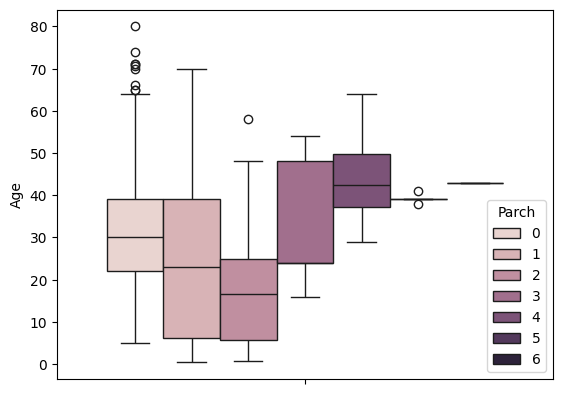

       count       mean        std    min    25%   50%    75%   max
Parch                                                              
0      519.0  32.109827  12.523548   5.00  22.00  30.0  39.00  80.0
1      110.0  24.422000  18.283117   0.42   6.25  23.0  39.00  70.0
2       68.0  17.216912  13.193924   0.83   5.75  16.5  25.00  58.0
3        5.0  33.200000  16.709279  16.00  24.00  24.0  48.00  54.0
4        4.0  44.500000  14.617341  29.00  37.25  42.5  49.75  64.0
5        5.0  39.200000   1.095445  38.00  39.00  39.0  39.00  41.0
6        1.0  43.000000        NaN  43.00  43.00  43.0  43.00  43.0


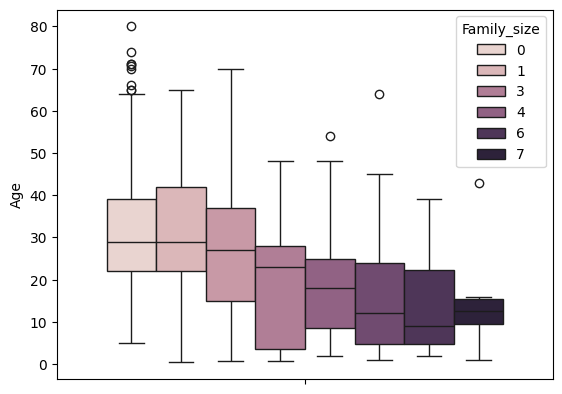

             count       mean        std   min    25%   50%    75%   max
Family_size                                                             
0            402.0  32.131841  12.842661  5.00  22.00  29.0  39.00  80.0
1            139.0  31.391511  13.484379  0.42  22.00  29.0  42.00  65.0
2             93.0  26.035806  16.542123  0.67  15.00  27.0  37.00  70.0
3             27.0  18.274815  14.304131  0.75   3.50  23.0  28.00  48.0
4             11.0  20.818182  17.069377  2.00   8.50  18.0  25.00  54.0
5             22.0  18.409091  17.388171  1.00   4.75  12.0  24.00  64.0
6             12.0  15.166667  14.732977  2.00   4.75   9.0  22.25  39.0
7              6.0  15.666667  14.361987  1.00   9.50  12.5  15.50  43.0


In [4]:
def map_values(df: pd.DataFrame, col_name: str, dict_to_map: dict)-> pd.DataFrame:
    """A convinience function for mapping mappin column values according to a given dictionary."""
    df[col_name] = df[col_name].map(dict_to_map)
    return df

def look_at_correlation(df: pd.DataFrame) -> None:

    df["Family_size"] = df["Parch"] + df["SibSp"]
    print("*****Spearman correlation*****")
    print(df.corr("spearman"))

    print("*****Age distribution in different categories*****")
    sns.boxplot(df, y="Age", hue="Pclass")
    plt.show()
    print(df.groupby("Pclass").describe())

    sns.boxplot(df, y="Age", hue="Parch")
    plt.show()
    print(df.groupby("Parch")["Age"].describe())

    df["Family_size"] = df["Parch"] + df["SibSp"]
    sns.boxplot(df, y="Age", hue="Family_size")
    plt.show()
    print(df.groupby("Family_size")["Age"].describe())


train_df = read_train_data()
train_df = train_df.drop(["Cabin", "PassengerId"], axis=1)
# Drop nan values. We are still planning on imputing Age later on
train_df = train_df.dropna()
train_df = map_values(train_df, "Sex", {"male": 0, "female": 1})
train_df = map_values(train_df, "Embarked", {"C": 0, "Q": 1, "S": 2})
look_at_correlation(train_df)


From the correlation table we can see that `Age` is correlated to `Parch`, `SibSp`, `Family_size` (sum of `Parch` and `SibSp`) and `Pclass`. After some exploration we notice that `Pclass` is the most straight forward way to impute age, since it has no missing datapoints and the classes differ in their age distributions. `Parch` and `Family_size` don't have such a linear correlation with age and using them would require a more sophisticated imputation method.

`Fare` is very correlated to `Pclass`. This might be problematic, because of multicollinearity.

### 2.4 A closer look at 'Fare'

Top 20 most expensive fares & count:
512.3292    3
263.0000    4
262.3750    2
247.5208    2
227.5250    4
221.7792    1
211.5000    1
211.3375    3
Name: Fare, dtype: int64


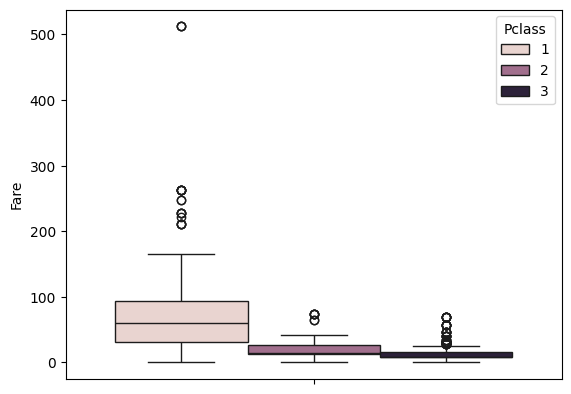


Spearman correlation: 
              Fare    Pclass  Survived
Fare      1.000000 -0.688032  0.323736
Pclass   -0.688032  1.000000 -0.339668
Survived  0.323736 -0.339668  1.000000
        count       mean        std  min       25%      50%   75%       max
Pclass                                                                     
1       216.0  84.154687  78.380373  0.0  30.92395  60.2875  93.5  512.3292
2       184.0  20.662183  13.417399  0.0  13.00000  14.2500  26.0   73.5000
3       491.0  13.675550  11.778142  0.0   7.75000   8.0500  15.5   69.5500


In [5]:
def look_at_fares(df: pd.DataFrame) -> None:
    print("Top 20 most expensive fares & count:")
    print(df["Fare"].sort_values(ascending=False)[0:20].value_counts(sort=False))

    sns.boxplot(df, y="Fare", hue="Pclass")
    plt.show()

    features = ["Fare", "Pclass", "Survived"]
    spearman_cor = df[features].corr("spearman")
    print(f"\nSpearman correlation: \n{spearman_cor}")

    print(df.groupby("Pclass")["Fare"].describe())


    
look_at_fares(read_train_data()) 

`Pclass` and `Fare` are highly correlated and `Fare` has some outliers (very expencive tickets) as well as some free tickets, so we are not going to use `Fare` for this prediction task.

### 2.5 Create imputation for age


In [6]:
def impute_age(df: pd.DataFrame) -> pd.DataFrame:
    """Impute missing ages by taking the mean age of the given 'Pclass'"""
    mean_ages  = df.groupby("Pclass")["Age"].mean()
    age_nans_filled = df[df["Age"].isna()].apply(lambda x: mean_ages[x["Pclass"]], axis=1)
    df["Age"] = df["Age"].fillna(age_nans_filled)    
    return df

train_df = read_train_data()
nan_index = train_df[train_df["Age"].isna()].index[:10]
print("***Sanity check***")
print("'Age' before imputation:")
print(train_df["Age"].describe())
print(train_df[train_df["Age"].isna()].iloc[:10, [0, 4]])
train_df= impute_age(train_df)

print("**************")
print("'Age' after imputation:")
#print(train_df.iloc[nan_index])
print(train_df["Age"].describe())
print(train_df.iloc[nan_index, [0,4]])


***Sanity check***
'Age' before imputation:
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
    PassengerId  Age
5             6  NaN
17           18  NaN
19           20  NaN
26           27  NaN
28           29  NaN
29           30  NaN
31           32  NaN
32           33  NaN
36           37  NaN
42           43  NaN
**************
'Age' after imputation:
count    891.000000
mean      29.292875
std       13.210527
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64
    PassengerId        Age
5             6  25.140620
17           18  29.877630
19           20  25.140620
26           27  25.140620
28           29  25.140620
29           30  25.140620
31           32  38.233441
32           33  25.140620
36           37  25.140620
42           43  25.140620


## 3. Create pipeline for prediction

In [7]:
def split_data(df: pd.DataFrame, target: str) -> tuple:
    """Suffle and split data into prediction and target sets for training and test."""
    y = df.loc[:,target]
    X = df.drop(target, axis=1)    
    return train_test_split(X, y, test_size=0.2, random_state=42)


def create_preprocessing_step(cat_data: list, num_data: list) -> ColumnTransformer:
    """Define pipelines for categorical data and numeric data. For categorical data, replace the missing values 
    with the most frequent value. For numerical data, use median value. Return 'ColumnTransformer'-object. Note,
    the custom age imputation should be done before this."""
    cat_pipeline = Pipeline(steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                                   ("encoder", OneHotEncoder(handle_unknown='ignore', min_frequency=0.05))
                                  ])
    num_pipeline = Pipeline(steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                                   ("scaler", RobustScaler())
                                  ])
    ct = ColumnTransformer(
        [("cat", cat_pipeline, cat_data),
         ("num", num_pipeline, num_data)
        ])
    return ct


def create_prediction_pipeline(preprocessing_step: ColumnTransformer, clf) -> Pipeline:
    """Define pipeline of given step and model with names 'preprocessing' and 'classifier'."""
    return Pipeline([("preprocessing", preprocessing_step),
                     ("classifier", clf)])

Next let's compare classification models. The logic follows the one depicted in: https://scikit-learn.org/1.5/auto_examples/classification/plot_classifier_comparison.html

In addition to comparing different models, we'll compare different feature sets just to be sure that more complex model actually improves the prediction.

We choose the best model according the accuracy score *(TP + TN) / (TP + TN + FP + FN)*, because that is the metric Kaggle uses to score our submission. 

In [8]:
def compare_models(cat_cols: list,
                   num_cols: list,
                   X_train: pd.DataFrame,
                   X_test: pd.DataFrame,
                   y_train: pd.DataFrame,
                   y_test: pd.DataFrame) -> None:
    """Create preprocessing step and select features to use in prediction. Train each model with these and calculate prediction score."""
    
    preprocessing_step = create_preprocessing_step(cat_cols, num_cols)
    X_train = X_train[cat_cols+num_cols]
    X_test = X_test[cat_cols+num_cols]

    classifier_names = [
        "LogisticRegeression",
        "SVC rbf",
        "SVC sigmoid",
        "Random Forest",
        "Naive Bayes"
    ]

    classifiers = [
        LogisticRegression(random_state=42),
        SVC(random_state=42),
        SVC(random_state=42, kernel="sigmoid"),
        RandomForestClassifier(random_state=42),
        GaussianNB()
    ]

    print(f"Scores with categorical cols: {cat_cols} and numerical cols: {num_cols} ")

    for name, clf in zip(classifier_names, classifiers):
        current_clf = create_prediction_pipeline(preprocessing_step, clf)
        current_clf.fit(X_train, y_train)
        acc = current_clf.score(X_test, y_test)
        print(f"\t Accuracy: {acc: .3f} for model {name}")
  
    print("fin")



def try_different_features(X_train: pd.DataFrame,
                           X_test: pd.DataFrame,
                           y_train: pd.DataFrame,
                           y_test: pd.DataFrame,
                           cols: list) -> None:
    """Function to make predictions with multiple models for different predictive features."""
    
    for cat_col, num_col in cols:
        print('*******')
        compare_models(cat_col, num_col, X_train, X_test, y_train, y_test)
    

train_df = impute_age(read_train_data())
X_train, X_test, y_train, y_test = split_data(train_df, "Survived")
cols = [[["Sex", "Pclass"],[]],
        [["Sex", "Pclass"],["Age", "Parch", "SibSp"]],
        [["Sex", "Pclass"],["Parch", "SibSp"]],
        [["Sex", "Pclass", "SibSp"], ["Age", "Parch"]],
        ]

try_different_features(X_train, X_test, y_train, y_test, cols)

*******
Scores with categorical cols: ['Sex', 'Pclass'] and numerical cols: [] 
	 Accuracy:  0.782 for model LogisticRegeression
	 Accuracy:  0.765 for model SVC rbf
	 Accuracy:  0.665 for model SVC sigmoid
	 Accuracy:  0.765 for model Random Forest
	 Accuracy:  0.782 for model Naive Bayes
fin
*******
Scores with categorical cols: ['Sex', 'Pclass'] and numerical cols: ['Age', 'Parch', 'SibSp'] 
	 Accuracy:  0.827 for model LogisticRegeression
	 Accuracy:  0.810 for model SVC rbf
	 Accuracy:  0.749 for model SVC sigmoid
	 Accuracy:  0.827 for model Random Forest
	 Accuracy:  0.754 for model Naive Bayes
fin
*******
Scores with categorical cols: ['Sex', 'Pclass'] and numerical cols: ['Parch', 'SibSp'] 
	 Accuracy:  0.793 for model LogisticRegeression
	 Accuracy:  0.793 for model SVC rbf
	 Accuracy:  0.620 for model SVC sigmoid
	 Accuracy:  0.782 for model Random Forest
	 Accuracy:  0.793 for model Naive Bayes
fin
*******
Scores with categorical cols: ['Sex', 'Pclass', 'SibSp'] and numeric

Logistic Regression and Random Forest give the best accuracy score `(0.827)` when using features all of the features `'Sex', 'Pclass', 'Age', 'Parch', 'SibSp'`. Let's see next if we can improve the accuracy with some hyperparameter tuning. This might improve the score especially with random forest.

In [9]:
def tune_classifier(param_grid: dict, 
                    clf, cat_col: list, 
                    num_col: list,  
                    X_train: pd.DataFrame, 
                    X_test: pd.DataFrame, 
                    y_train: pd.DataFrame, 
                    y_test: pd.DataFrame) -> GridSearchCV:

    ct = create_preprocessing_step(cat_col, num_col)
    pipe = create_prediction_pipeline(ct, clf)
    grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    test_score = grid_search.score(X_test, y_test)
    print("Accuracy test score:", test_score)
    print("Accuracy train score:", grid_search.best_score_)
    print("With params:", grid_search.best_params_)
    print("*****")
    return grid_search


train_df = impute_age(read_train_data())

cat_col = ['Sex', 'Pclass']
num_col = ['Age', 'Parch', 'SibSp']
train_df = train_df[['Sex', 'Pclass','Age', 'Parch', 'SibSp',"Survived"]]
X_train, X_test, y_train, y_test = split_data(train_df, "Survived")

reg_grid = {
            "classifier__max_iter": [50, 75, 100, 150, 200],
            "classifier__C": [0.01, 0.1, 1, 1.5, 10],
            "classifier__solver": ["newton-cg", "lbfgs", "liblinear"],
            }

rf_grid = {
    'classifier__n_estimators': [30, 70, 100, 150],
    'classifier__max_depth': [None, 2, 4, 6, 8],
    'classifier__min_samples_split': [2, 4, 6], 
    'classifier__min_samples_leaf': [2, 4, 6], 
    'classifier__max_features': [0.1, 0.5, 1, "sqrt"],
    'classifier__max_samples': [None, 0.5, 0.9],
    }



reg_search = tune_classifier(reg_grid, LogisticRegression(random_state=42), cat_col, num_col, X_train, X_test, y_train, y_test)
rf_search = tune_classifier(rf_grid, RandomForestClassifier(random_state=42), cat_col, num_col, X_train, X_test, y_train, y_test)
print("Pipeline for random forest clssifier:")
rf_search.best_estimator_

Accuracy test score: 0.8044692737430168
Accuracy train score: 0.8019714214799843
With params: {'classifier__C': 0.1, 'classifier__max_iter': 50, 'classifier__solver': 'newton-cg'}
*****
Accuracy test score: 0.8044692737430168
Accuracy train score: 0.8300712690139348
With params: {'classifier__max_depth': 4, 'classifier__max_features': 0.5, 'classifier__max_samples': 0.5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 100}
*****
Pipeline for random forest clssifier:


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=0.05))]),
                                                  ['Sex', 'Pclass']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Parch', 'SibSp'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=4, max_features=0.5,
                                        max_samples=0.5, min_samples_leaf=2,
                                        min_samples_split=6,
                                        random_state=42))])

The accuracy scores are not too promising after tuning. For logistic regression model this could be because there aren't that much hyperparameters to tune to begin with.

For random forest the result is a bit more suprising. There is not a huge difference between train and test scores, which indicates that ovefitting might not be the issue here. It could be that the parameter grid is poorly constructed or that the data is not good enough for this model. Because the time running the grid search is long (12m!) and the results are not that promising, we are not going to try grid search again with new parameters, but rather just see what our score will be with this model. 


## 4. Prediction

Next we make the actual prediction for the competition. We use the random forest -model (trained above with grid search) to make predictions and save the results in a file called "prediction.csv". This contains columns `PassengerId` (for identyfining passengers) and `Survived` (our prediction).

In [10]:
def make_final_prediction(model: Pipeline, df: pd.DataFrame) -> None:
    pred = model.predict(df[['Sex', 'Pclass','Age', 'Parch', 'SibSp']])
    resulst_df = pd.DataFrame({"PassengerId": df["PassengerId"], "Survived": pred})
    resulst_df.to_csv("prediction.csv", index=False)

# Read test data
test_df = impute_age(read_test_data())

# Suffle rows
test_df = test_df.sample(frac=1)

# Select the features used in training and `PassengerId` 
test_df = test_df[['PassengerId', 'Sex', 'Pclass','Age', 'Parch', 'SibSp']]

make_final_prediction(rf_search.best_estimator_, test_df)


## 5. Reflection

This prediction scored 0.76076 on Kaggle, so there is definitely some work left to do.
- We could gain some new insight from feature `Cabin`, because cabin locations do not necessarly correspond to class. Because a lot of cabin info is missing, we need to find a way to predict the missing data.
- We also ignored `Fare`, although we ended up using a random forest classifier, which could potentially handle multicollinearity.
- We could create new features that better reflect the passenger. For example, it would seem plausible that a child traveling alone would have lower changes of survival than a child traveling with parents.
- We could try using more complex models, such as neural networks, that might find more sophisticated connections within the data.
- Some features and the target value were unevenly distributed, which we did not handle at all. Some class imbalance techniques could improve the score. 